# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")

all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


## Predictions with markers

In [4]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [5]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [6]:
from model_nb_classifier import ModelNBClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier



def train_and_predict(df, min_df=None):
    m = ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", min_df=min_df, trigger_words=ptm_trigger_words)
    m.train(df["x"], df["y"])
    return m, m.predict(df["x"])[0]



In [7]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, latex=True, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=labels,zero_division=0)
        df =  pd.DataFrame(d).T
        df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
        
        print(df.to_latex(formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
        return df

In [8]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [9]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

In [11]:
m = ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", trigger_words=ptm_trigger_words)

## Train GT Train predictions

In [12]:
df_train = pd.read_json(trainfile, orient="records")
m.train(df_train["x"], df_train["y"])
train_pred = m.predict(df_train["x"])[0]

print_report(df_train["y"], train_pred, False, pos_labels)

print_report(df_train["y"], train_pred, False, all_labels)



(1305, 11)
(1305, 11)
              precision    recall  f1-score   support

           1       0.73      0.51      0.60       139
           2       0.76      0.57      0.65        28
           3       0.62      0.50      0.56        10
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67         2

   micro avg       0.73      0.49      0.59       189
   macro avg       0.52      0.35      0.41       189
weighted avg       0.69      0.49      0.58       189

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1116
           1       0.73      0.51      0.60       139
           2       0.76      0.57      0.65        28
           3       0.62      0.50      0.56        10
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67         2

 

In [13]:
get_top_discrimintary_keywords(m, 4)


[('protpart1', -3.301113923105173),
 ('protpart0', -3.7806870033670594),
 ('prtig0', -4.399726211773283),
 ('protein', -4.473834183927005),
 ('degradation', -4.553876891600542),
 ('proteins', -4.640888268590171),
 ('cell', -4.841558964052322),
 ('cells', -4.959341999708705),
 ('transcription', -4.959341999708705),
 ('prtig1', -4.959341999708705),
 ('dependent', -5.092873392333228),
 ('expression', -5.092873392333228),
 ('ubiquitin', -5.247024072160487),
 ('dna', -5.247024072160487),
 ('ubiquitination', -5.429345628954441),
 ('human', -5.429345628954441),
 ('suppressor', -5.429345628954441),
 ('activity', -5.429345628954441),
 ('phase', -5.429345628954441),
 ('protpart1 degradation', -5.429345628954441),
 ('depletion', -5.429345628954441),
 ('mediated', -5.429345628954441),
 ('function', -5.652489180268651),
 ('cell cycle', -5.652489180268651),
 ('kinases', -5.652489180268651),
 ('levels', -5.652489180268651),
 ('depletion protpart1', -5.652489180268651),
 ('cycle', -5.652489180268651),

## Val GT predictions


In [14]:
df_val = pd.read_json(valfile, orient="records")
val_pred = m.predict(df_val["x"])[0]
print_report(df_val["y"], val_pred, False, pos_labels)

print_report(df_val["y"], val_pred, False, all_labels)




(200, 11)
              precision    recall  f1-score   support

           1       0.57      0.38      0.46        21
           2       0.30      0.30      0.30        10
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.46      0.32      0.38        34
   macro avg       0.15      0.11      0.13        34
weighted avg       0.44      0.32      0.37        34

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       166
           1       0.57      0.38      0.46        21
           2       0.30      0.30      0.30        10
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg 

## Test 

### Predict Test on Train GT fit

In [15]:
df_test = pd.read_json(testfile, orient="records")
df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report(df_test["y"], df_test["train_shortcut_pred"], False, pos_labels)

print_report(df_test["y"], df_test["train_shortcut_pred"], True, pos_labels)




(352, 11)
              precision    recall  f1-score   support

           1       0.65      0.39      0.49        44
           2       0.60      0.50      0.55         6
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.64      0.38      0.47        56
   macro avg       0.29      0.19      0.23        56
weighted avg       0.61      0.38      0.46        56

              precision    recall  f1-score   support

           1       0.65      0.39      0.49        44
           2       0.60      0.50      0.55         6
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.64      0.38      0.47        56
   macro avg 

,precision,recall,f1-score,support
Phosphorylation,0.653846,0.386364,0.485714,44.0
Dephosphorylation,0.600000,0.500000,0.545455,6.0
Methylation,0.500000,0.250000,0.333333,4.0
Ubiquitination,0.000000,0.000000,0.000000,1.0
Acetylation,0.000000,0.000000,0.000000,1.0
Deubiquitination,0.000000,0.000000,0.000000,0.0
micro avg,0.636364,0.375000,0.471910,56.0
macro avg,0.292308,0.189394,0.227417,56.0
weighted avg,0.613736,0.375000,0.463884,56.0


### Predict Test on Test GT fit

In [16]:

df_test["shortcut_pred"] = train_and_predict(df_test, min_df=1)[1]
l_test_gt = print_report(df_test["y"],df_test["shortcut_pred"], False, all_labels)
l_test_gt = print_report(df_test["y"],df_test["shortcut_pred"], True, pos_labels)

(352, 11)
(352, 11)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       296
           1       0.67      0.64      0.65        44
           2       1.00      0.83      0.91         6
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.90      0.90      0.90       352
   macro avg       0.61      0.56      0.58       352
weighted avg       0.90      0.90      0.90       352

              precision    recall  f1-score   support

           1       0.67      0.64      0.65        44
           2       1.00      0.83      0.91         6
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   

### Predict Test on Test Prediction fit 

(352, 11)
(352, 11)


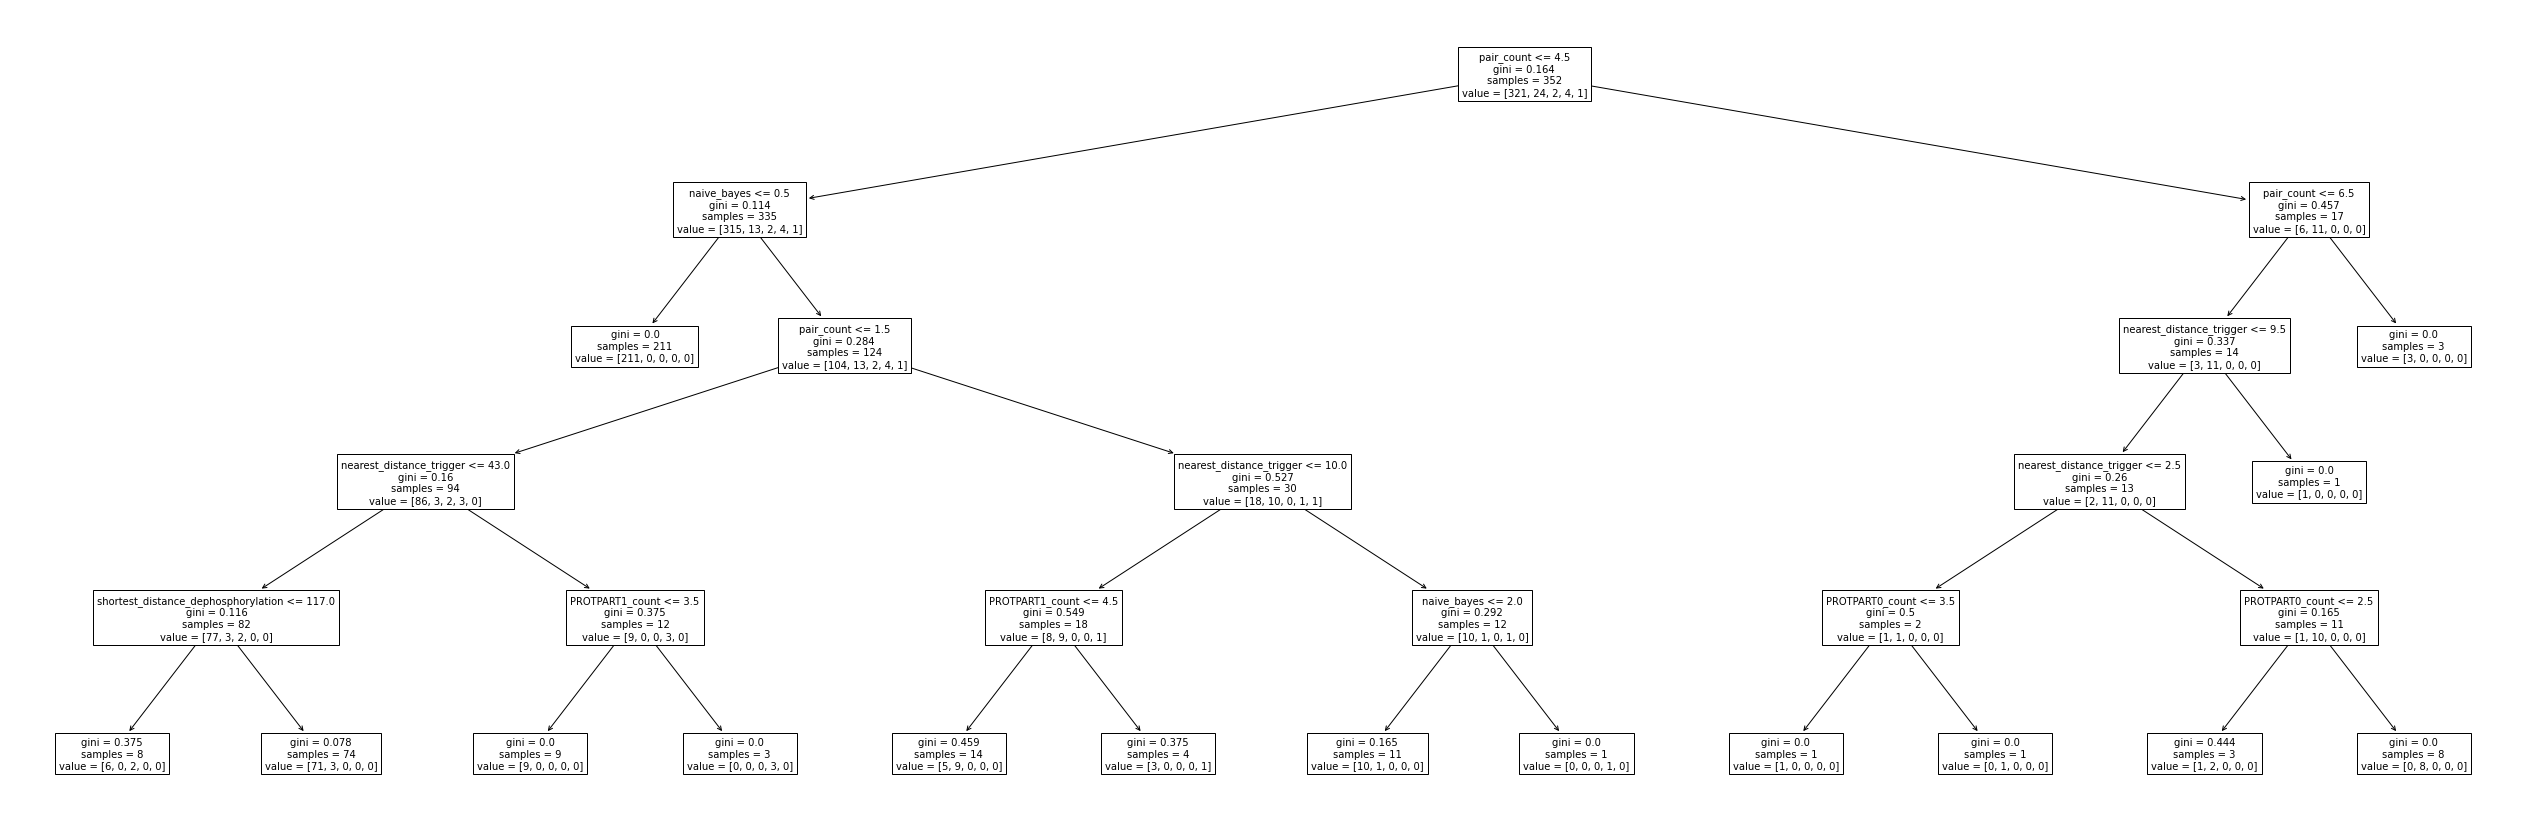

              precision    recall  f1-score   support

           1       0.77      0.83      0.80        24
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.80      0.77      0.79        31
   macro avg       0.29      0.31      0.30        31
weighted avg       0.72      0.77      0.75        31

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       321
           1       0.77      0.83      0.80        24
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.96

In [17]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

t_m, df_test_prediction["shortcut_pred"] = train_and_predict(df_test_prediction, min_df=1)

plot_tree(t_m)


print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], False, pos_labels)

l_test_pred =  print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], True, pos_labels)

In [18]:
print(l_test_pred.merge(l_test_gt, left_index = True, right_index=True).to_latex(float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  precision\_x &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
Phosphorylation   &        76.9 &     83.3 &       80.0 &    2400.0 &        66.7 &     63.6 &       65.1 &    4400.0 \\
Dephosphorylation &         0.0 &      0.0 &        0.0 &     200.0 &       100.0 &     83.3 &       90.9 &     600.0 \\
Methylation       &       100.0 &    100.0 &      100.0 &     400.0 &        66.7 &     50.0 &       57.1 &     400.0 \\
Ubiquitination    &         0.0 &      0.0 &        0.0 &       0.0 &       100.0 &    100.0 &      100.0 &     100.0 \\
Acetylation       &         0.0 &      0.0 &        0.0 &     100.0 &         0.0 &      0.0 &        0.0 &     100.0 \\
Deubiquitination  &         0.0 &      0.0 &        0.0 &       0.0 &         0.0 &      0.0 &        0.0 &       0.0 \\
micro avg         &        96.3 &     96.3 &       96.3 &   35200.0 &        70.6 &     64.3 &       67.3 &

## Fit large scale hq

In [ ]:
df_largescale_hq = load_large_scale(largescalefile)
largescale_hq_m, df_largescale_hq["shortcut_pred"] = train_and_predict(df_largescale_hq)
plot_tree(largescale_hq_m)


print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], False, pos_labels)

print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], False, all_labels)



In [ ]:
print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], latex=True)



In [ ]:
plot_confusionmatrix(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"])
plt.savefig(os.path.join(temp_dir,"confusionMatrixPTMPHC.png"))

## Fit large scale low quality

In [ ]:
df_low_quality = load_large_scale(largescale_low_hq)
df_low_quality["shortcut_pred"] = train_and_predict(df_low_quality)[1]



In [ ]:
# Custom train
print_report(df_low_quality["y"], df_low_quality["shortcut_pred"])



In [ ]:
plot_confusionmatrix(df_low_quality["y"], df_low_quality["shortcut_pred"])

In [ ]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    pred_class, pred_prob = m.predict(df["x"])
    df_t["nb_pred"] = pred_class
    df_t["nb_pred_conf"] = pred_prob
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


plot_confidence(prep_data(df_largescale_hq, largescale_hq_m))

plt.show()


